# Predicción usando Deep Learning con datos numéricos
En este notebook implementaremos una red neuronal de regresión teniendo en cuenta solo los datos numéricos (sin imágenes).

Usaremos una red neuronal MLP (Multiplayer Perceptron)

## Lectura dataset
Recuperamos los datasets de train y test que ya teníamos limpios.

In [19]:
import pandas as pd
import os
from sklearn import preprocessing

# Carga el dataset y devuelve un dataframe de Pandas
def load_dataset(ruta,nombre,separador=';'):
    csv_path = os.path.join(ruta, nombre)
    return pd.read_csv(csv_path, sep=separador)

In [2]:
copTrain = load_dataset('datasets', 'train_final.csv')
copTest = load_dataset('datasets', 'test_final.csv')

## Escalado de características

In [3]:
train_vote_average = copTrain['vote_average']
test_vote_average = copTest['vote_average']

train_sin_y = copTrain.drop(['vote_average'], axis=1, inplace=False)
test_sin_y = copTest.drop(['vote_average'], axis=1, inplace=False)

y_train = train_vote_average.values
X_train = train_sin_y.values

y_test = test_vote_average.values
X_test = test_sin_y.values

feature_names = copTrain.columns[:]

In [4]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
XtestScaled = scaler.transform(X_test)

## Red Neuronal (MLP)

In [5]:
import tensorflow as tf
#tf.enable_eager_execution()

In [6]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
print( tf.constant( 'Hellow from TensorFlow ' + tf.__version__ ) )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17749256256812236872
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3063309926
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14071241766969559359
physical_device_desc: "device: 0, name: GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:03:00.0, compute capability: 7.5"
]
Tensor("Const:0", shape=(), dtype=string)


In [7]:
# Obtener precio máximo en Train, y escalamos los precios de test y train en rango de [0, 1]
maxPrice = copTrain["vote_average"].max()
trainY = copTrain["vote_average"] / maxPrice
testY = copTest["vote_average"] / maxPrice

In [8]:
# Número de características
XtrainScaled.shape

(7921, 66)

Para calcular el nº de neuronas por capa oculta uso la Regla de la pirámide geométrica.

Tenemos 66 características (66 neuronas de entrada), al ser un problema de regresión, solo tendremos una neurona de salida.

Dividiré por 3 capas ocultas de la siguiente forma:

r = raíz cuarta de 66/1 r = 3

h1 = 1 * 3^3 = 27

h2 = 1 * 3^2 = 9

h3 = 1 * 3 = 3

In [9]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

def create_mlp(dim):
	# define our MLP network
	model = Sequential()
	model.add(Dense(27, input_dim=dim, activation="relu"))
	model.add(Dense(9, activation="relu"))
	model.add(Dense(3, activation="relu"))
	model.add(Dense(1, activation="linear"))
	
	return model

Using TensorFlow backend.


In [10]:
model = create_mlp(XtrainScaled.shape[1])
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer=opt)

historico = model.fit(XtrainScaled, trainY, validation_data=(XtestScaled, testY),
    epochs=10, batch_size=27)








Train on 7921 samples, validate on 1977 samples
Epoch 1/10





7921/7921 [==============================] - 1s 181us/step - loss: 0.0788 - val_loss: 0.0318
Epoch 2/10
7921/7921 [==============================] - 1s 107us/step - loss: 0.0239 - val_loss: 0.0235
Epoch 3/10
7921/7921 [==============================] - 1s 109us/step - loss: 0.0186 - val_loss: 0.0204
Epoch 4/10
7921/7921 [==============================] - 1s 109us/step - loss: 0.0165 - val_loss: 0.0189
Epoch 5/10
7921/7921 [==============================] - 1s 109us/step - loss: 0.0157 - val_loss: 0.0185
Epoch 6/10
7921/7921 [==============================] - 1s 108us/step - loss: 0.0150 - val_loss: 0.0181
Epoch 7/10
7921/7921 [==============================] - 1s 107us/step - loss: 0.0147 - val_loss: 0.0185
Epoch 8/10
7921/7921 [==============================] - 1s 109us/step - loss: 0.0146 - val_loss: 0.0178
Epoch 9/10
7921/7921 [==============================] - 1s 107us/step - loss: 0.0143 - val_loss: 0.0177
Epoc

### Curva de pérdidas de los datos de train y test

Text(0, 0.5, 'Loss')

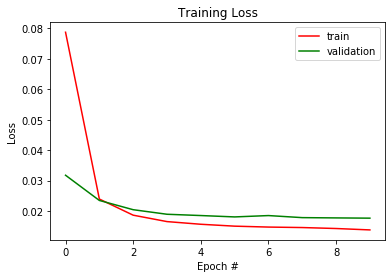

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0, 10), historico.history["loss"], 'r')
plt.plot(np.arange(0, 10), historico.history["val_loss"], 'g')
plt.title("Training Loss")
plt.legend(['train','validation'])
plt.xlabel("Epoch #")
plt.ylabel("Loss")

Como se puede ver, la curva converge pronto y a partir de la época 8 práctiacamente el modelo no mejora.

## Evaluación del modelo
Una vez entrenado el modelo, lo evaluamos y vemos el resumen de resultados.

In [45]:
preds = model.predict(XtestScaled)

# Cargar dataset original
df = load_dataset('datasets', 'db_practica_kc_public_dataset_final.csv', ',')

# Comprobar la diferencia entre las valoraciones que ha predecido con los que tenemos en el dataset
diff = preds.flatten() - testY

percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# Hay alguna valoración de test 0, al dividir da inf, lo reemplazamos por 0
absPercentDiff = absPercentDiff.replace([np.inf, -np.inf], 0)

# Calculamos la media y la desviación estándar
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# Vemos las estadísticas
print('[INFO] media valoración película: ', df["vote_average"].mean(), 
      ', desviación valoración película: ', df["vote_average"].std())

print("[INFO] media del error: {:.2f}%, desviación del error: {:.2f}%".format(mean, std))

[INFO] media valoración película:  6.2358199999999995 , desviación valoración película:  1.4887862761516863
[INFO] media del error: 12.08%, desviación del error: 13.81%


## Resultados
Nuestra red neuronal nos da una pérdida de 0.0138 en train y 0.0177 en test.

El cálculo del error absoluto es de 12.08%, esto significa que de promedio nuestra red se alejará un 12,08% en las predicciones de las valoraciones de las películas, con una desviación del 13,81%.

In [55]:
import sys
np.set_printoptions(threshold=sys.maxsize)
pd.set_option("display.max_rows", None)

In [56]:
print(preds.flatten())

[ 0.62237364  0.5991005   0.67313063  0.6344501   0.6011606   0.58367884
  0.6644596   0.64937454  0.6281645   0.6194891   0.6649423   0.6053614
  0.6691954   0.72589433  0.6323242   0.57075965  0.61825055  0.61665744
  0.6311159   0.6338253   0.6815881   0.67359024  0.6381753   0.6209144
  0.67379236  0.63761204  0.66306365  0.5921286   0.5843072   0.6708965
  0.6666623   0.64690024  0.7093399   0.62702477  0.5530367   0.7114873
  0.6538467   0.60302776  0.6016448   0.6601236   0.65676796  0.6430792
  0.63315105  0.6462547   0.67008126  0.6518475   0.6533827   0.6634694
  0.6650611   0.5909263   0.5910498   0.6257413   0.6076158   0.652249
  0.61390954  0.6607311   0.6455857   0.6438314   0.6221136   0.6938555
  0.6232468   0.6864728   0.5899234   0.56019145  0.6456276   0.6149566
  0.66194826  0.68937325  0.6402898   0.6271458   0.61176187  0.4057578
  0.66682065  0.6375633   0.6120196   0.6299192   0.65480304  0.60316885
  0.71118027  0.67646873  0.7070996   0.6092882   0.61629415  

In [48]:
print(testY)

0       0.71
1       0.54
2       0.61
3       0.68
4       0.48
5       0.60
6       0.57
7       0.62
8       0.57
9       0.55
10      0.61
11      0.59
12      0.72
13      0.76
14      0.62
15      0.74
16      0.66
17      0.65
18      0.58
19      0.65
20      0.54
21      0.70
22      0.65
23      0.45
24      0.66
25      0.64
26      0.68
27      0.66
28      0.73
29      0.78
30      0.71
31      0.63
32      0.84
33      0.72
34      0.59
35      0.67
36      0.82
37      0.65
38      0.74
39      0.69
40      0.52
41      0.64
42      0.59
43      0.65
44      0.61
45      0.77
46      0.71
47      0.67
48      0.76
49      0.59
50      0.68
51      0.60
52      0.46
53      0.72
54      0.65
55      0.71
56      0.67
57      0.66
58      0.65
59      0.71
60      0.73
61      0.65
62      0.59
63      0.56
64      0.56
65      0.77
66      0.72
67      0.59
68      0.70
69      0.66
70      0.56
71      0.79
72      0.69
73      0.67
74      0.63
75      0.47
76      0.60

In [50]:
print(type(preds))

<class 'numpy.ndarray'>


## Comprobar las predicciones con los valores reales
Vamos a comparar las predicciones obtenidas con los valores reales.

Antes que eso comprobamos que las dimensiones de las predicciones con los datos reales son las mismas:

In [58]:
preds.shape

(1977, 1)

In [59]:
testY.shape

(1977,)

Los devolvemos a escala normal:

In [60]:
pred_escala_normal = preds * maxPrice

In [62]:
test_y_escala_normal = testY * maxPrice

In [65]:
print(type(test_y_escala_normal))

<class 'pandas.core.series.Series'>


In [67]:
# Convertimos las valoraciones reales a dataframe de pandas
df_pruebas = test_y_escala_normal.to_frame()

In [68]:
df_pruebas

,vote_average
0,7.1
1,5.4
2,6.1
3,6.8
4,4.8
5,6.0
6,5.7
7,6.2
8,5.7
9,5.5


In [69]:
# Cambiamos el nombre a la columna
df_pruebas.rename(columns={"vote_average": "vote_average_real"})

,vote_average_real
0,7.1
1,5.4
2,6.1
3,6.8
4,4.8
5,6.0
6,5.7
7,6.2
8,5.7
9,5.5


In [ ]:
# Convertimos predicciones a dataframe de pandas